####**Load Dataset from Hugging Face**

In [ ]:
# Install required packages
!pip install datasets --quiet

In [ ]:
# Find Colab environment
import os

colab_env = os.environ.get('GOOGLE_CLOUD_PROJECT')
if colab_env == None:
    print("Using Colab Research")
else:
    print("Using Colab Enterprise")

Using Colab Enterprise


In [ ]:
# Login to Hugging Face
from huggingface_hub import login

if colab_env == None:
    # Get access token from Hugging Face hub
    from google.colab import userdata

    HF_TOKEN = userdata.get('HF_TOKEN')
else:
    # Get access token from Secret Manager
    !pip install google-cloud-secret-manager --quiet
    from google.cloud import secretmanager

    client = secretmanager.SecretManagerServiceClient()
    project_id = !gcloud config get-value project
    secret_name = f"projects/{project_id[0]}/secrets/HF_TOKEN/versions/latest"
    response = client.access_secret_version(request={"name": secret_name})
    HF_TOKEN = response.payload.data.decode("UTF-8")

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please set the token first.")

Successfully logged in to Hugging Face!


In [ ]:
# Load Hugging Face dataset dict Sp1786/multiclass-sentiment-analysis-dataset
from datasets import load_dataset

dataset_dict = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")
print("Multiclass Sentiment Analysis dataset:")
print(dataset_dict)

Multiclass Sentiment Analysis dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5206
    })
})


####**Learn Data**

In [ ]:
# Load datasets into dataframe
import pandas as pd

df_train = pd.DataFrame(dataset_dict["train"])
df_val = pd.DataFrame(dataset_dict["validation"])
df_test = pd.DataFrame(dataset_dict["test"])

print("Shape of train split:", df_train.shape)
print("Shape of test validation:", df_val.shape)
print("Shape of test split:", df_test.shape)

print("\nData types of train split:\n", df_train.dtypes)

print("\nHead of train split:")
df_train.head()

Shape of train split: (31232, 4)
Shape of test validation: (5205, 4)
Shape of test split: (5206, 4)

Data types of train split:
 id            int64
text         object
label         int64
sentiment    object
dtype: object

Head of train split:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [ ]:
# Find duplicates in all splits
duplicates_in_train = len(df_train["text"]) - len(df_train["text"].drop_duplicates())
duplicates_in_val = len(df_val["text"]) - len(df_val["text"].drop_duplicates())
duplicates_in_test = len(df_test["text"]) - len(df_test["text"].drop_duplicates())

print("Number of duplicates in train split (text column):", duplicates_in_train)
print("Number of duplicates in val split (text column):", duplicates_in_val)
print("Number of duplicates in test split (text column):", duplicates_in_test)

Number of duplicates in train split (text column): 0
Number of duplicates in val split (text column): 0
Number of duplicates in test split (text column): 0


In [ ]:
# Find missing values in all splits
nulls_in_train = df_train.isnull().sum().sum()
nulls_in_val = df_train.isnull().sum().sum()
nulls_in_test = df_train.isnull().sum().sum()

print("Number of missing values in train split:", nulls_in_train)
print("Number of missing values in val split:", nulls_in_val)
print("Number of missing values in test split:", nulls_in_test)

Number of missing values in train split: 0
Number of missing values in val split: 0
Number of missing values in test split: 0


####**Visualizations**

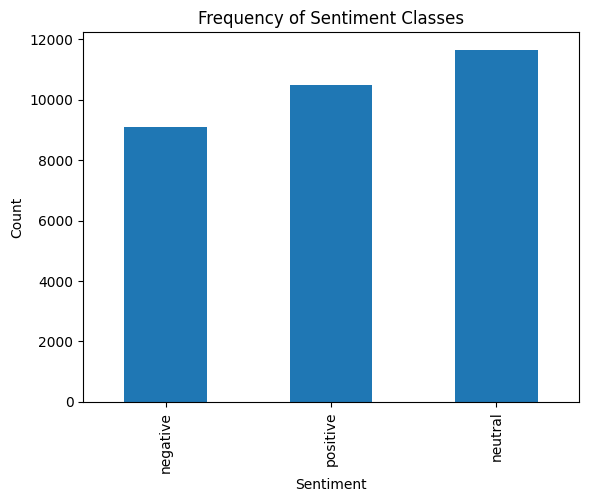

In [ ]:
# Plot sentiment class distribution bar chart of train split
import matplotlib.pyplot as plt

df_train["sentiment"].value_counts(ascending=True).plot.bar()
plt.title("Frequency of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

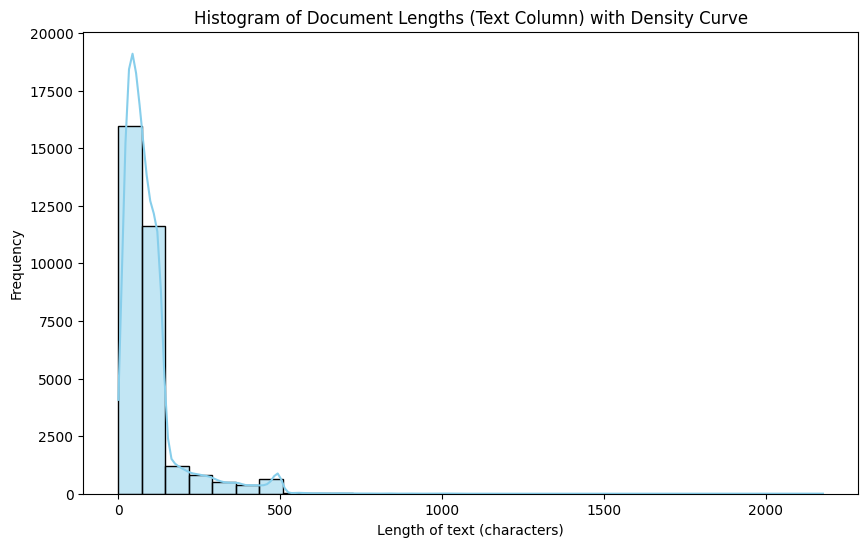

In [ ]:
# Plot histogram of document lengths of text column in train set
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each document (question)
s_doc_length = df_train["text"].apply(len)

# Plot histogram of document lengths
plt.figure(figsize=(10, 6))
sns.histplot(s_doc_length, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Document Lengths (Text Column) with Density Curve')
plt.xlabel('Length of text (characters)')
plt.ylabel('Frequency')
plt.show()

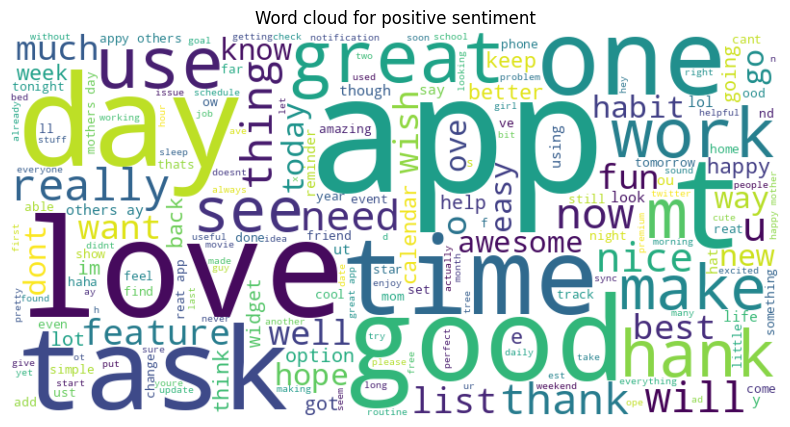

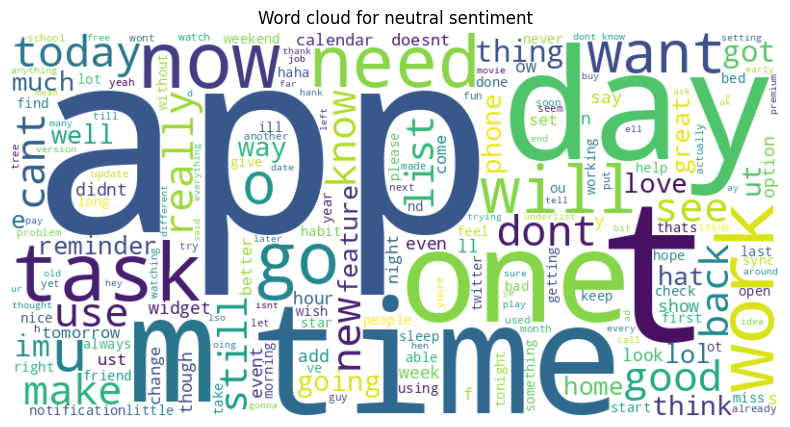

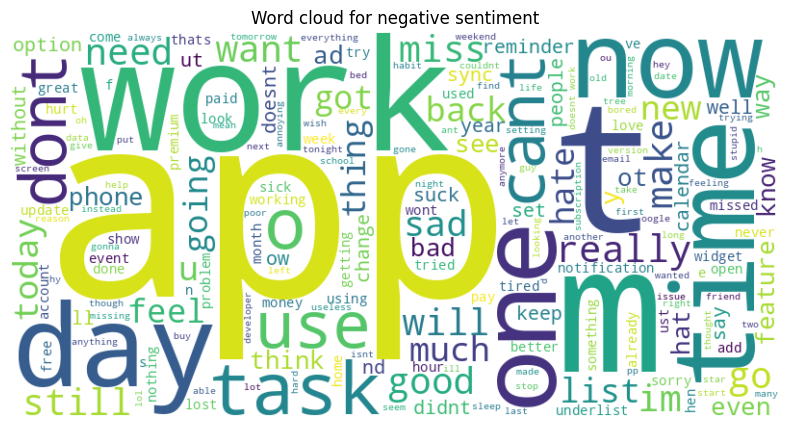

In [ ]:
# Generate word cloud per sentiment class of train split
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

def plot_word_cloud( texts: str) -> object:
    # Combine all questions into single string and remove punctuation
    texts = " ".join(texts)
    texts = re.sub(r'[^a-z\s]', '', texts)

    # Create stopwords list (optional - can add custom stopwords)
    stopwords = set(STOPWORDS)

    # Generate word cloud object
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords,
        max_words=200
    ).generate(texts)
    return wordcloud

positive_texts = df_train[df_train["sentiment"] == "positive"]["text"]
positive_wordcloud = plot_word_cloud(positive_texts)

neutral_texts = df_train[df_train["sentiment"] == "neutral"]["text"]
neutral_wordcloud = plot_word_cloud(neutral_texts)

negative_texts = df_train[df_train["sentiment"] == "negative"]["text"]
negative_wordcloud = plot_word_cloud(negative_texts)

# Plot the word clouds
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Word cloud for positive sentiment")
plt.show()

plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title("Word cloud for neutral sentiment")
plt.show()

plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Word cloud for negative sentiment")
plt.show()

####**Preprocess data**

In [ ]:
# Load tokenizer
from transformers import AutoTokenizer

model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Tokenize all datasets
def tokenize_function(batch):
    texts = [str(x) if x is not None else "" for x in batch["text"]]
    return tokenizer(texts, padding=True, truncation=True)

ds_train = dataset_dict["train"]
ds_val = dataset_dict["validation"]
ds_test = dataset_dict["test"]
tokenized_train = ds_train.map(tokenize_function, batched=True)
tokenized_val = ds_val.map(tokenize_function, batched=True)
tokenized_test = ds_test.map(tokenize_function, batched=True)


Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

####**Save data**

In [ ]:
# Create Hugging Face DatasetDict
from datasets import DatasetDict

sentiment_analysis_tokenized = DatasetDict({
    'train': tokenized_train,
    'validation': tokenized_val,
    'test': tokenized_test
})

print("Tokenized sentiment analysis dataset:")
print(sentiment_analysis_tokenized)

Tokenized sentiment analysis dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5206
    })
})


In [ ]:
# Push DatasetDict to Hugging Face hub
sentiment_analysis_tokenized.push_to_hub("anjan-k/Sentiment-Analysis-Tokenized")
print("Tokenized sentiment analysis dataset dict pushed to Hugging Face hub")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/32 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########| 4.34MB / 4.34MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  76%|#######6  |  562kB /  737kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########|  720kB /  720kB            

Tokenized sentiment analysis dataset dict pushed to Hugging Face hub
